### TEMPLATE MATCHING


En este trabajo práctico se busca la identificación de objetos a través de diferentes algoritmos, entre ellos **template matchin**.


In [26]:
# Import libraries
import numpy as np
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
import scipy.stats as st
from PIL import Image

# %matplotlib


### Ejercicio 1


### Detección del logo en cada imagen


In [27]:
def scale_img():
    pattern = cv.imread('./imgs/tp3/template/pattern.png', 0)
    img_bitwise_list = []
    img_resized_list = []

    # Multi-scale
    for scale in np.linspace(0.1, 1.0, 10)[::-1]:
        img_resized = imutils.resize(
            pattern, width=int(pattern.shape[1] * scale))
        r = pattern.shape[1]/float(img_resized.shape[1])

        # img_canny = cv.Canny(img_resized, 50, 200)
        img_bitwise = cv.bitwise_not(img_resized)
        img_bitwise_list.append(img_bitwise)
        img_resized_list.append(img_resized)
        # img_canny_list.append(img_canny)

        # plt.figure()
        # plt.imshow(img_resized)
    return img_bitwise_list, img_resized_list

In [28]:
def read_imag():
    """Function to read images of different formats from specific folder

    Returns:
        np.array: Images transformed in different types like blur images or grayscale images.
    """    
    img_dir = './imgs/tp3/images/'
    ext = ['png', 'jpg']
    files = []
    image_gray = []
    images_blur = []
    imgs_color = []
    [files.extend(glob.glob(img_dir + '*.' + e)) for e in ext]

    images = [cv.imread(file) for file in files]

    for im in images:
        img_color = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        
        img_blur = cv.GaussianBlur(img_color, (5,5), 0)
        blur_image = cv.cvtColor(img_blur,cv.COLOR_BGR2GRAY )
        images_blur.append(blur_image)
        
        img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
        image_gray.append(img_gray)
        
        imgs_color.append(img_color)

    return images_blur, image_gray, imgs_color


In [29]:
def logo_detection()->None:
    imgs_blur, imgs_gray, images_color = read_imag()
    pattern_resized_list = []
    pattern = cv.imread('./imgs/tp3/template/pattern.png', 0)

    found = None
    for i,j  in zip(range(len(imgs_gray)), range(len(images_color))):
        
        # Multi-scale
        for scale in np.linspace(0.5, 3.5, 90)[::-1]:
            pattern_resized = imutils.resize(
                pattern, width=int(pattern.shape[1] * scale))
                 
            if pattern_resized.shape[1] > imgs_gray[i].shape[1]:
                continue
            if pattern_resized.shape[1]>=1200 and pattern_resized.shape[0]>=500:
                pattern_resized_list.append(pattern_resized)
        if j == 6:
            pattern_resized = pattern_resized_list[2]
            print(f'Match')
       
        w_pattern_resized, h_pattern_resized = pattern_resized.shape[::-1]

        #Edge detection for the pattern image
        image_canny_pattern = cv.Canny(
            pattern_resized, threshold1=100, threshold2=200)
        
        #Edge detection for the image where it will be detected the logo.
        img_canny = cv.Canny(imgs_gray[i], threshold1=200, threshold2=700)

        print("[INFO] performing template matching...")
        method = 'cv.TM_CCOEFF_NORMED'

        #Template matching between imagen pattern and  where it will be 
        #detected the logo.
        img_match = cv.matchTemplate(
            img_canny, image_canny_pattern, eval(method))
        (minVal, maxVl, minLoc, maxLoc) = cv.minMaxLoc(img_match)
        
        # Place where the match was found
        top_left = maxLoc
        
        bottom_rigth = (top_left[0] + w_pattern_resized,
                        (top_left[1] + h_pattern_resized))

        cv.rectangle(images_color[j], top_left, bottom_rigth, (0, 0, 255), 2)

        # Results of matching
        plt.subplot(121), plt.imshow(img_match, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

        # Original image with bounding box
        plt.subplot(122), plt.imshow(images_color[j])
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

        plt.suptitle(method)
        plt.show()
    return

[INFO] performing template matching...


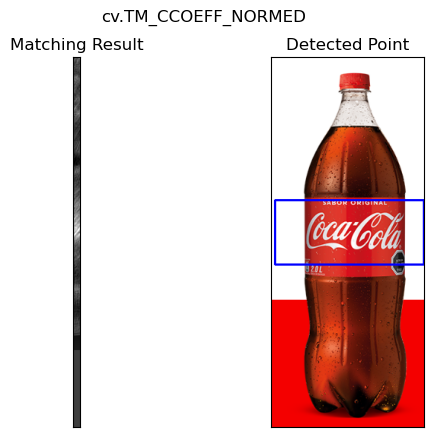

[INFO] performing template matching...


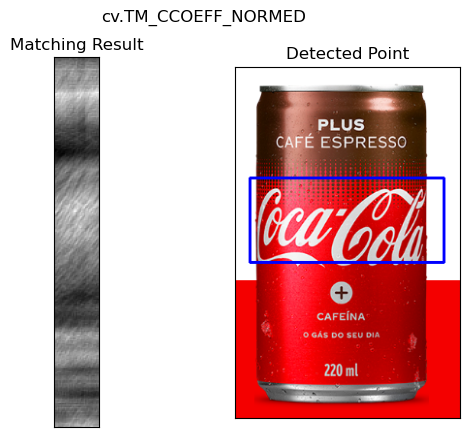

[INFO] performing template matching...


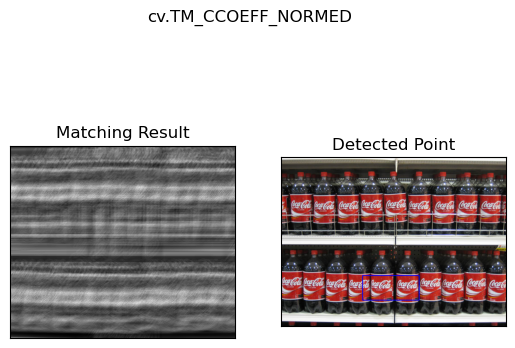

[INFO] performing template matching...


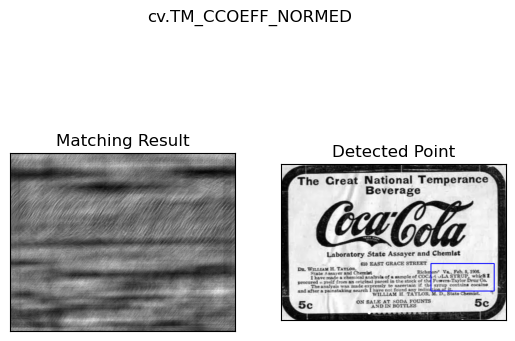

[INFO] performing template matching...


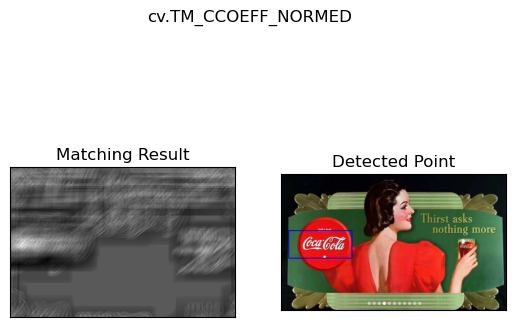

[INFO] performing template matching...


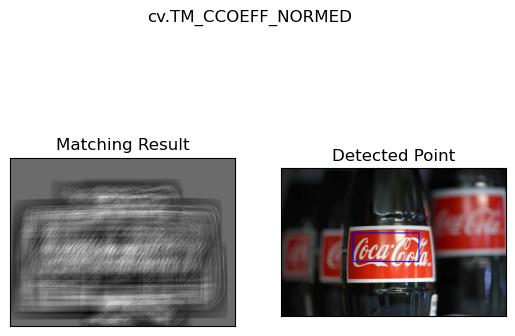

Match
[INFO] performing template matching...


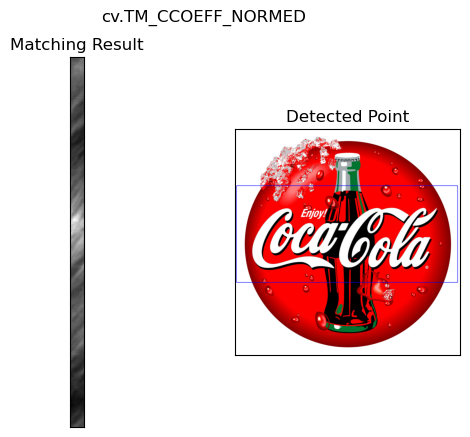

In [35]:
logo_detection()

In [31]:
def logo_detection_multi(img_path:str):
    """This function could be used for multiple
    detection logo. 


    Args:
        img_path (str): path where the image to be processed 
        is located.
    """    
    img = cv.imread(img_path)
    img_coca_cola = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_coca_cola_gray = cv.cvtColor(img_coca_cola, cv.COLOR_BGR2GRAY)
    img_bitwise_list, img_resized_list = scale_img()

    img_template = (img_bitwise_list[8])
    method = 'cv.TM_CCORR_NORMED'

    w, h = img_template.shape[::-1]
    res = cv.matchTemplate(
        img_coca_cola_gray, img_template, eval(method))
    
    # Fijamos un umbral de "coincidencia"
    threshold = 0.63
    
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        cv.rectangle(img_coca_cola, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(img_template, cmap='gray')
    plt.title('Pattern')

    plt.subplot(122)
    plt.imshow(img_coca_cola)
    plt.title('Result')

    # cv.imwrite('res.png',img_rgb)
    return

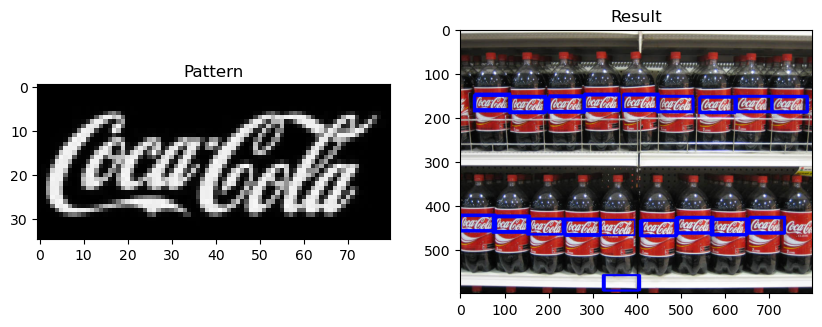

In [32]:
image_path = './imgs/tp3/images/coca_multi.png'
logo_detection_multi(image_path)

### Ejercicio 3


In [33]:
def detection() -> None:
    """Function to detect logos in multiples images with
    confidence intervals.
    """    
    imgs_blur, imgs_gray, images_color = read_imag()
    max_value_list = []
    pattern_resized_list = []
    pattern = cv.imread('./imgs/tp3/template/pattern.png', 0)

    found = None
    for i, j in zip(range(len(imgs_gray)), range(len(images_color))):
        
        # Multi-scale
        for scale in np.linspace(0.5, 4, 90)[::-1]:
            pattern_resized = imutils.resize(
                pattern, width=int(pattern.shape[1] * scale))
            
            if pattern_resized.shape[1] > imgs_gray[i].shape[1]:
                continue
        
            w_pattern_resized, h_pattern_resized = pattern_resized.shape[::-1]

        image_canny_pattern = cv.Canny(
            pattern_resized, threshold1=200, threshold2=500)
        img_canny = cv.Canny(imgs_gray[i], threshold1=400, threshold2=700)

        print("[INFO] performing template matching...")
        method = 'cv.TM_CCOEFF_NORMED'
        img_match = cv.matchTemplate(
        img_canny, image_canny_pattern, eval(method))
        (minVal, maxVl, minLoc, maxLoc) = cv.minMaxLoc(img_match)

        max_value_list.append(maxVl)


        CI = 0.7

        threshold = 0.063*CI
        if max_value_list[j] >= threshold:
            threshold = max_value_list[j]

        loc = np.where(img_match >= threshold)
        for pt in zip(*loc[::-1]):
            cv.rectangle(images_color[j], pt, (pt[0] + w_pattern_resized,
                         pt[1] + h_pattern_resized), (0, 0, 255), 2)

        # Results of matching
        plt.subplot(121), plt.imshow(img_match, cmap='gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

        # Original image with bounding box
        plt.subplot(122), plt.imshow(images_color[j])
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

        plt.suptitle(method)
        plt.show()
    return

[INFO] performing template matching...


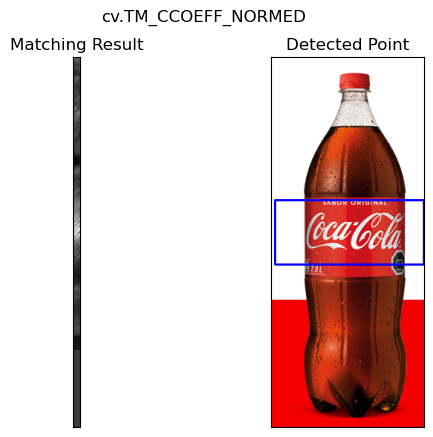

[INFO] performing template matching...


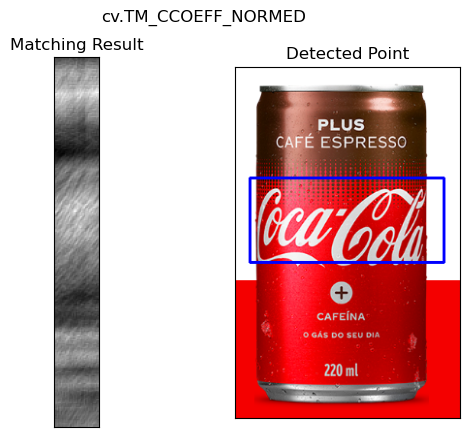

[INFO] performing template matching...


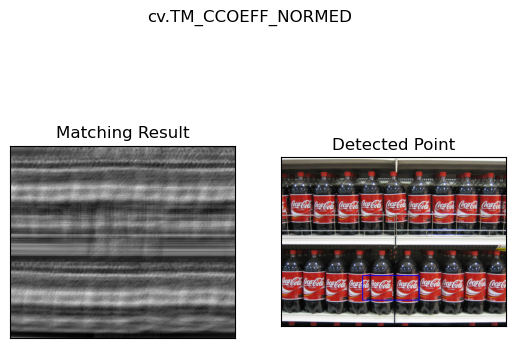

[INFO] performing template matching...


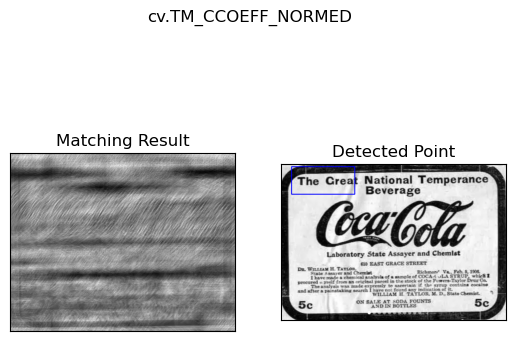

[INFO] performing template matching...


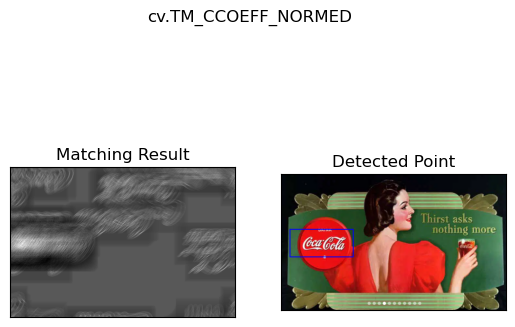

[INFO] performing template matching...


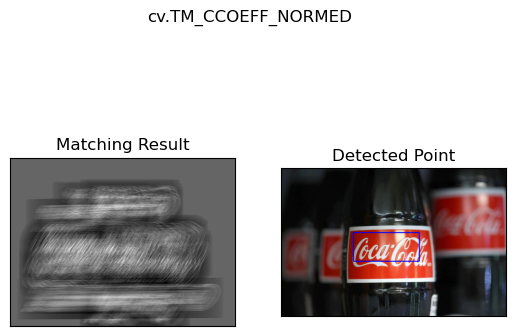

[INFO] performing template matching...


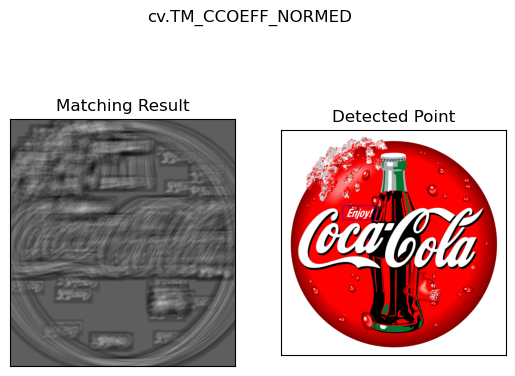

In [34]:
detection()